# Conditional DCGANs
The generator and discriminator also receive a label as input. Therefore, the generator is not only forced generate realistic images, but those images should also belong to a specific class. On the other hand, the Discriminator must also learn how to tell whether an example is real and belongs to a specified class

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Flatten, Dropout, Reshape, Conv2DTranspose, BatchNormalization, Dense, LeakyReLU, ReLU, Input
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# Generator
The input of the generator is $Z$ of size $100$ (*NOISE_DIM*) plus an additional one-hot vector of size $10$ (*CLASSES*, the number of classes in MNIST). The rest of the network architecture is identical to the one used for classic DCGANs.

In [2]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

def block(m, fs, stride):  
    m.add(Conv2DTranspose(
      filters=fs,
      kernel_size=(5, 5), 
      strides=stride, 
      padding='same', 
      use_bias=False,
      kernel_initializer=initializer
    ))
    m.add(BatchNormalization(momentum=0.5, scale=False))
    m.add(ReLU())

NOISE_DIM = 100
WIDTH = 28
CLASSES = 10

G = tf.keras.Sequential();
G.add(Input(shape=[NOISE_DIM + CLASSES]))
G.add(Dense(7*7*512, use_bias=False, kernel_initializer=initializer))
G.add(BatchNormalization(momentum=0.5))
G.add(ReLU())
G.add(Reshape((7, 7, 512)))
block(G, 256, (1, 1))
block(G, 128, (2, 2))
G.add(Conv2DTranspose(1, (5, 5), (2, 2), padding='same', activation='tanh', kernel_initializer=initializer))

### Running the generator

(1, 28, 28, 1)


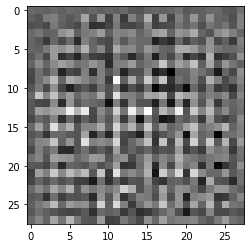

In [3]:
eg_noise_sd = tf.random.normal([1, NOISE_DIM])
eg_noise_lb = tf.one_hot(1, CLASSES)
eg_noise = tf.concat([eg_noise_sd, [eg_noise_lb]], axis=1)
eg_gen = G(eg_noise, training = False)
print(eg_gen.shape)
denorm = ((eg_gen[0] * 127.5) + 127.5).numpy().astype(np.uint8).squeeze(2)
plt.imshow(denorm, cmap="gray")

# Discriminator
The generator generates an image of shape `[WIDTH, WIDTH, 1]`. In the case of conditional DCGANs, we have to inject the label of the example as a one-hot vector. We do this by adding one row to the input, extending it's shape to `[WIDTH + 1, WIDTH, 1]`. The rest of the network is identical to the classic DCGAN discriminator

In [4]:
def dblock(m, chs, stride):
    m.add(Conv2D(chs, (5, 5), (stride, stride), 'same', use_bias=False, kernel_initializer=initializer))
    m.add(BatchNormalization(momentum=0.5))
    m.add(LeakyReLU(0.2))

D = tf.keras.Sequential()
D.add(Input(shape=[WIDTH + 1, WIDTH, 1]))
dblock(D, 32, 2)
dblock(D, 64, 2)
dblock(D, 128, 2)
D.add(Flatten())
D.add(Dense(1, activation="sigmoid", kernel_initializer=initializer))

### Running the discriminator

In [5]:
cl = tf.slice(eg_noise[0], [NOISE_DIM], [CLASSES])
cl = tf.pad(cl, [[0, WIDTH - CLASSES]], "CONSTANT")
cl = tf.reshape(cl, [1, 1, WIDTH, 1])
res = tf.concat([eg_gen, cl], axis=1)
print(D(res))

tf.Tensor([[0.4998611]], shape=(1, 1), dtype=float32)


# Training
The training loop is identical to the one used for DCGANs

In [6]:
BCE = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
  real_loss = BCE(tf.ones_like(real_output), real_output)
  fake_loss = BCE(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss
  
def generator_loss(fake_output):
  return BCE(tf.ones_like(fake_output), fake_output)

g_optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)
d_optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)

def noises_per_class(num_per_class):
  seed_noises = tf.random.normal([num_per_class * CLASSES, NOISE_DIM])
  labels = tf.repeat(tf.eye(CLASSES), tf.fill([CLASSES], num_per_class), axis=0)
  seed = tf.concat([seed_noises, labels], axis=1)
  return seed

EXAMPLES_PER_CLASS = CLASSES
SEED = noises_per_class(EXAMPLES_PER_CLASS)

@tf.function
def train_step(batch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      noise = tf.random.normal([batch.shape[0], NOISE_DIM])
      labels_idxs = tf.random.uniform([batch.shape[0]], maxval=CLASSES, dtype=tf.int32)
      onehots = tf.one_hot(labels_idxs, CLASSES)
      inputs = tf.concat([noise, onehots], axis=1)
      generated_images = G(inputs, training=True)
      
      lbls = tf.pad(onehots, [[0, 0], [0, WIDTH - CLASSES]], "CONSTANT")
      lbls = tf.reshape(lbls, [batch.shape[0], 1, WIDTH, 1])
      generated_images_labels = tf.concat([generated_images, lbls], axis=1)
      
      real_output = D(batch, training=True)
      fake_output = D(generated_images_labels, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

      gradients_of_generator = gen_tape.gradient(gen_loss, G.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, D.trainable_variables)

      g_optimizer.apply_gradients(zip(gradients_of_generator, G.trainable_variables))
      d_optimizer.apply_gradients(zip(gradients_of_discriminator, D.trainable_variables))

def train(dataset, epochs, info):
  for epoch in range(epochs):
    print("Epoch {}/{}:".format(epoch+1, epochs))
    progbar = tf.keras.utils.Progbar(len(dataset))
    for image_batch in dataset:
      train_step(image_batch)
      progbar.add(1)
      
    if (epoch+1) % 2 == 0:
      show_generations(SEED, info)

def show_generations(seed, info):
  imgs = G(seed, training=False)
  plt.figure(figsize=(18, 18))
  for i in range(imgs.shape[0]):
      img = tf.slice(imgs[i], [0, 0, 0], [WIDTH, WIDTH, 1])
      label = tf.math.argmax(tf.slice(seed[i], [NOISE_DIM], [CLASSES]))
      label_name = info.features["label"].names[label]
      ax = plt.subplot(CLASSES, EXAMPLES_PER_CLASS, i+1)
      ax.set_title(label_name)
      plt.axis("off")
      plt.imshow((img * 127.5 + 127.5).numpy().squeeze(2).astype(np.uint8), cmap="gray")
  plt.show()

Epoch 1/20:
469/469 [==============================] - 20s 37ms/step
Epoch 2/20:
469/469 [==============================] - 16s 35ms/step


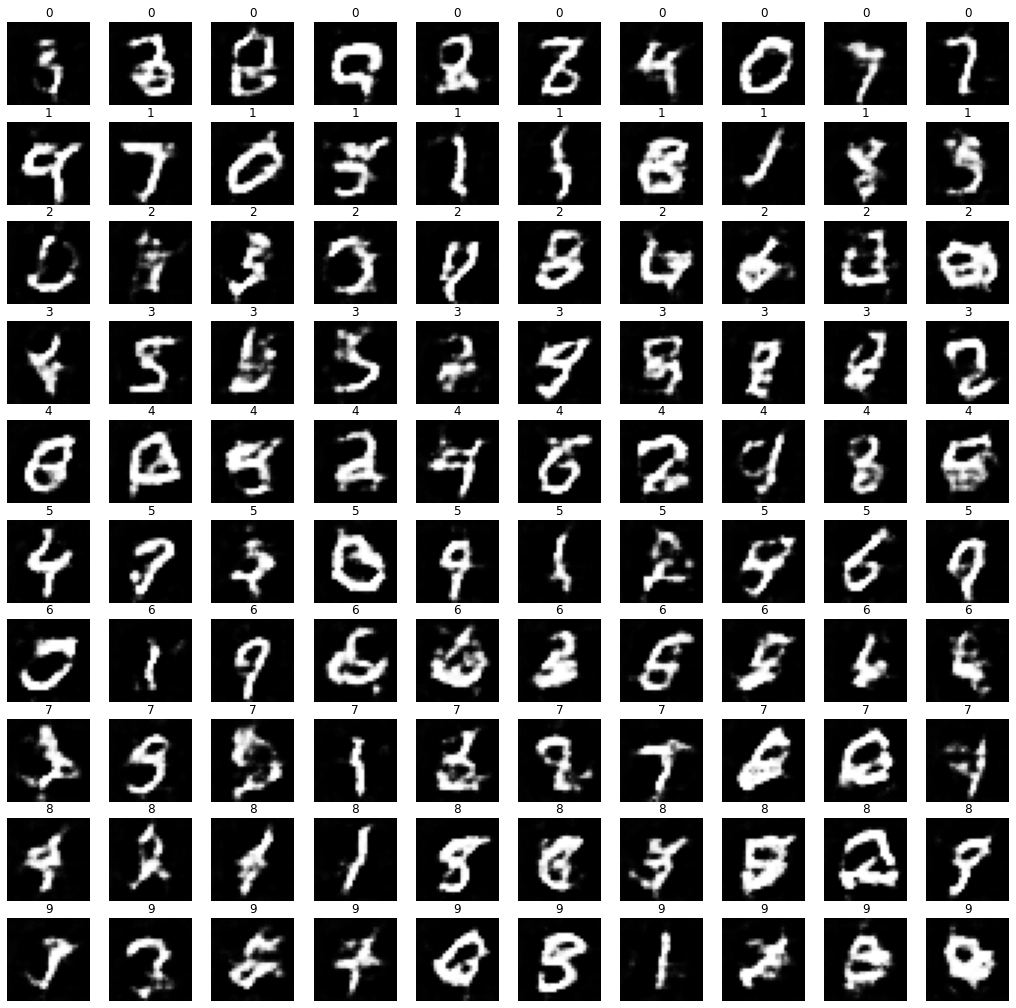

Epoch 3/20:
469/469 [==============================] - 16s 35ms/step
Epoch 4/20:
469/469 [==============================] - 16s 35ms/step


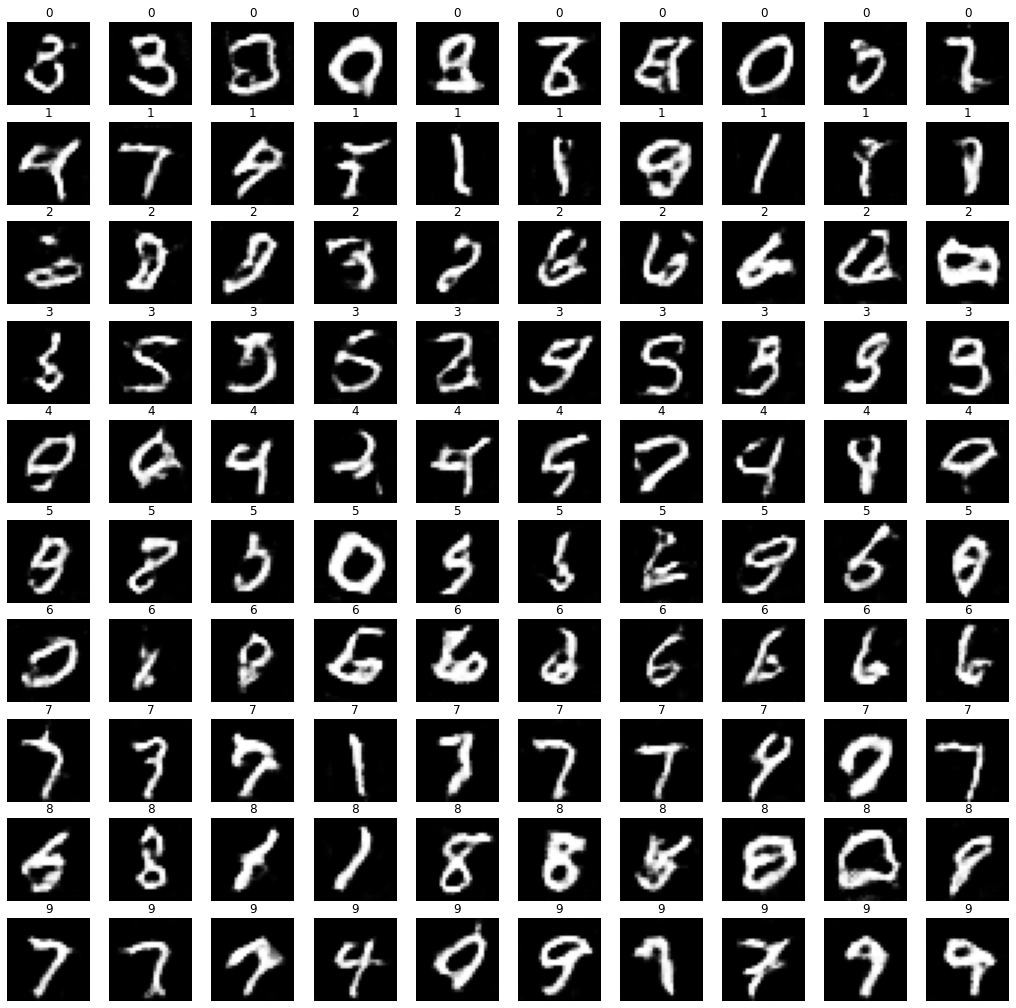

Epoch 5/20:
469/469 [==============================] - 16s 35ms/step
Epoch 6/20:
469/469 [==============================] - 16s 35ms/step


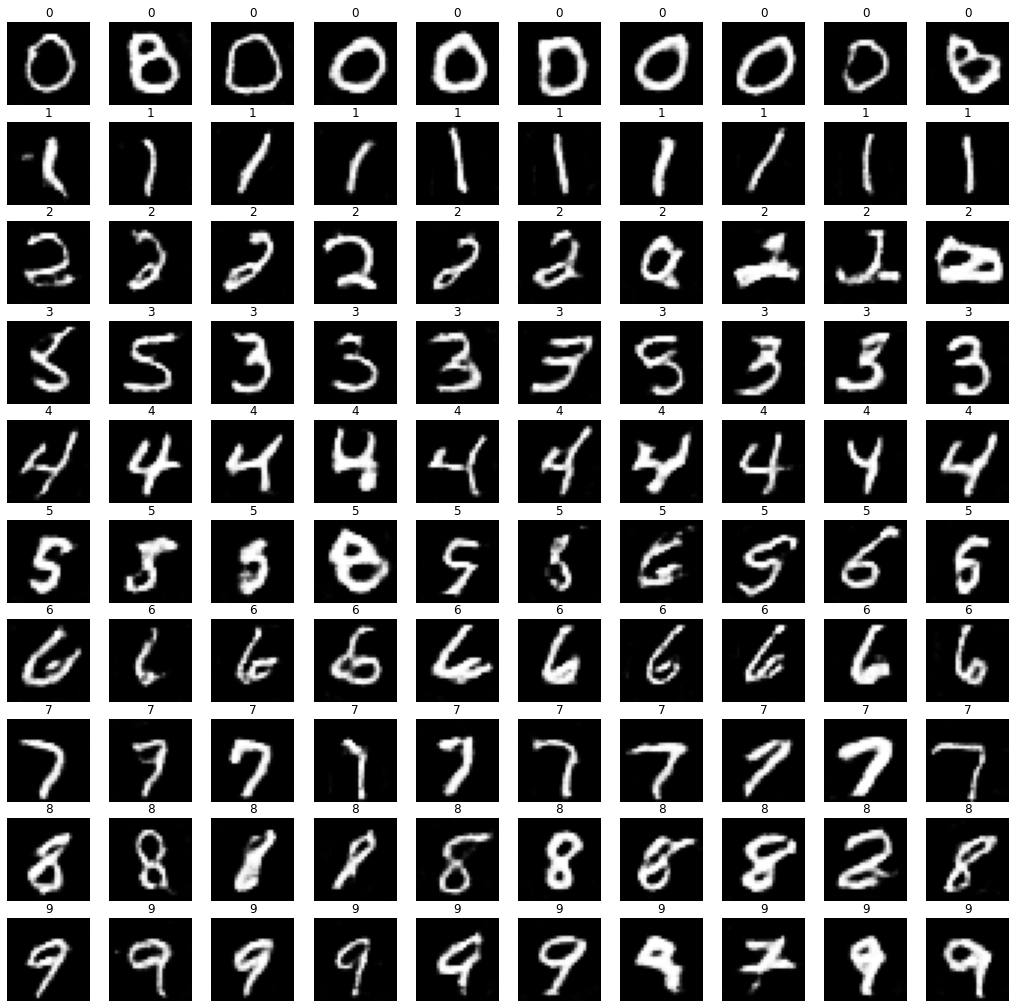

Epoch 7/20:
469/469 [==============================] - 16s 35ms/step
Epoch 8/20:
469/469 [==============================] - 17s 35ms/step


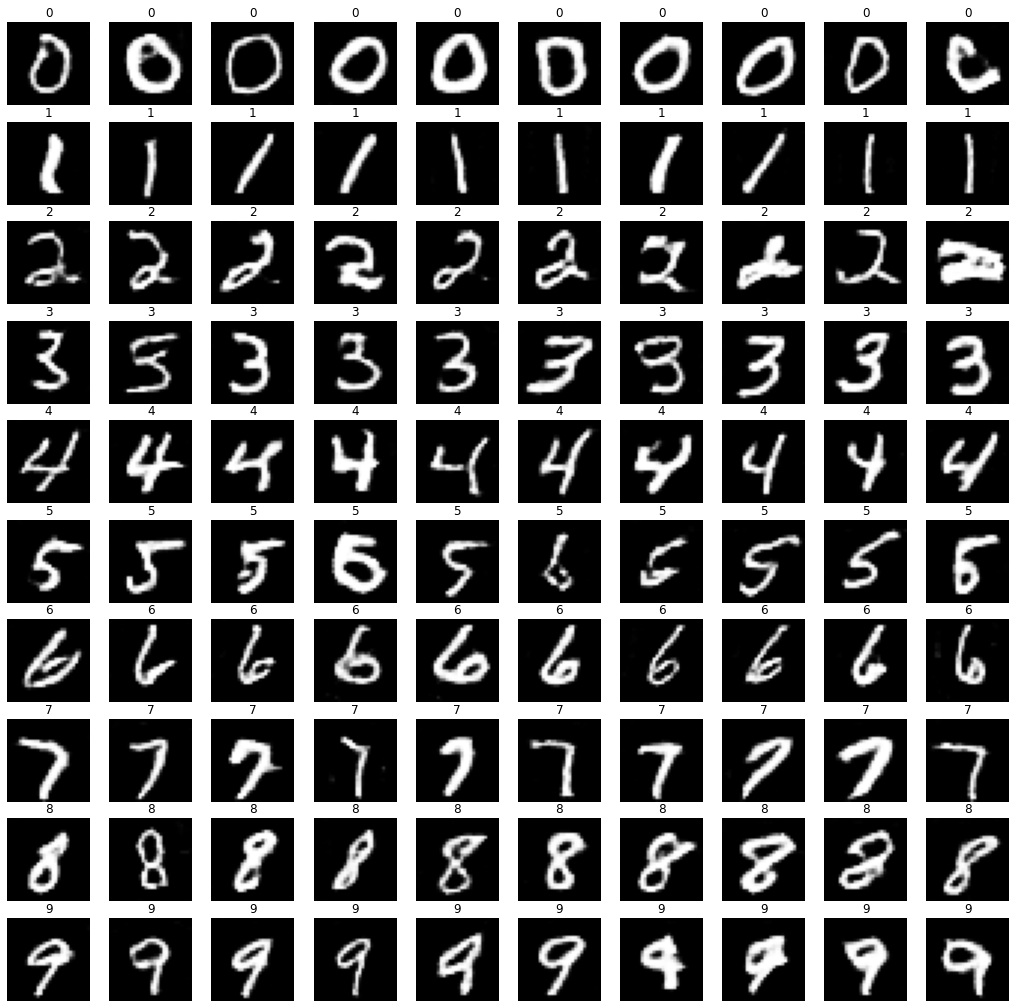

Epoch 9/20:
469/469 [==============================] - 17s 35ms/step
Epoch 10/20:
469/469 [==============================] - 17s 35ms/step


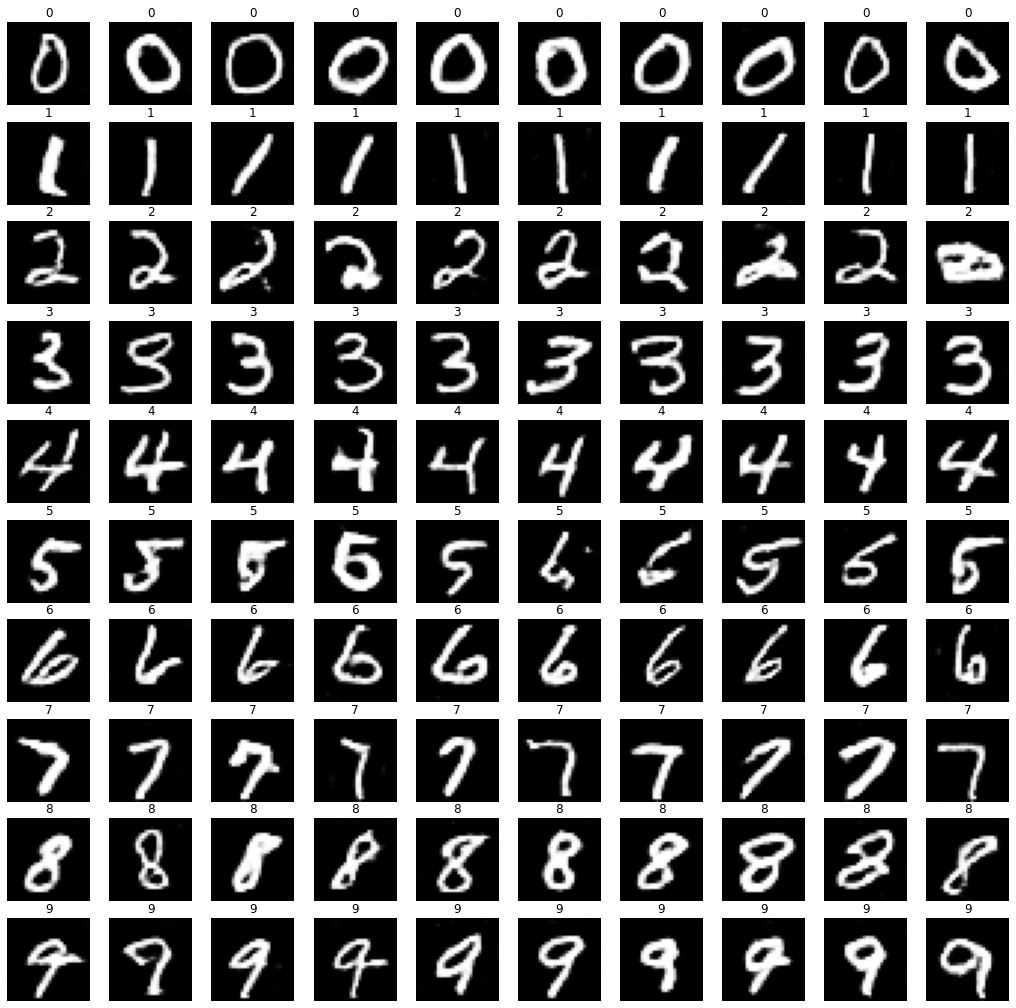

Epoch 11/20:
469/469 [==============================] - 17s 35ms/step
Epoch 12/20:
469/469 [==============================] - 17s 35ms/step


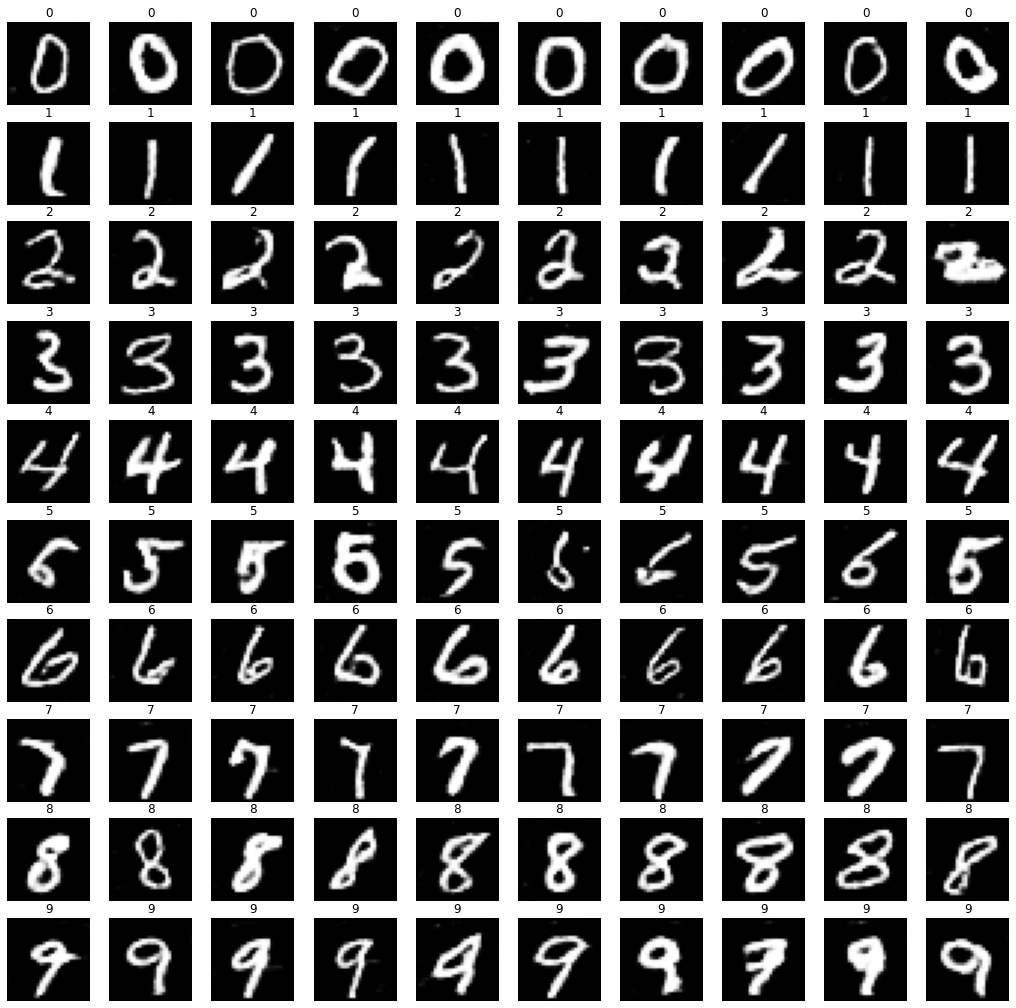

Epoch 13/20:
469/469 [==============================] - 17s 35ms/step
Epoch 14/20:
469/469 [==============================] - 17s 35ms/step


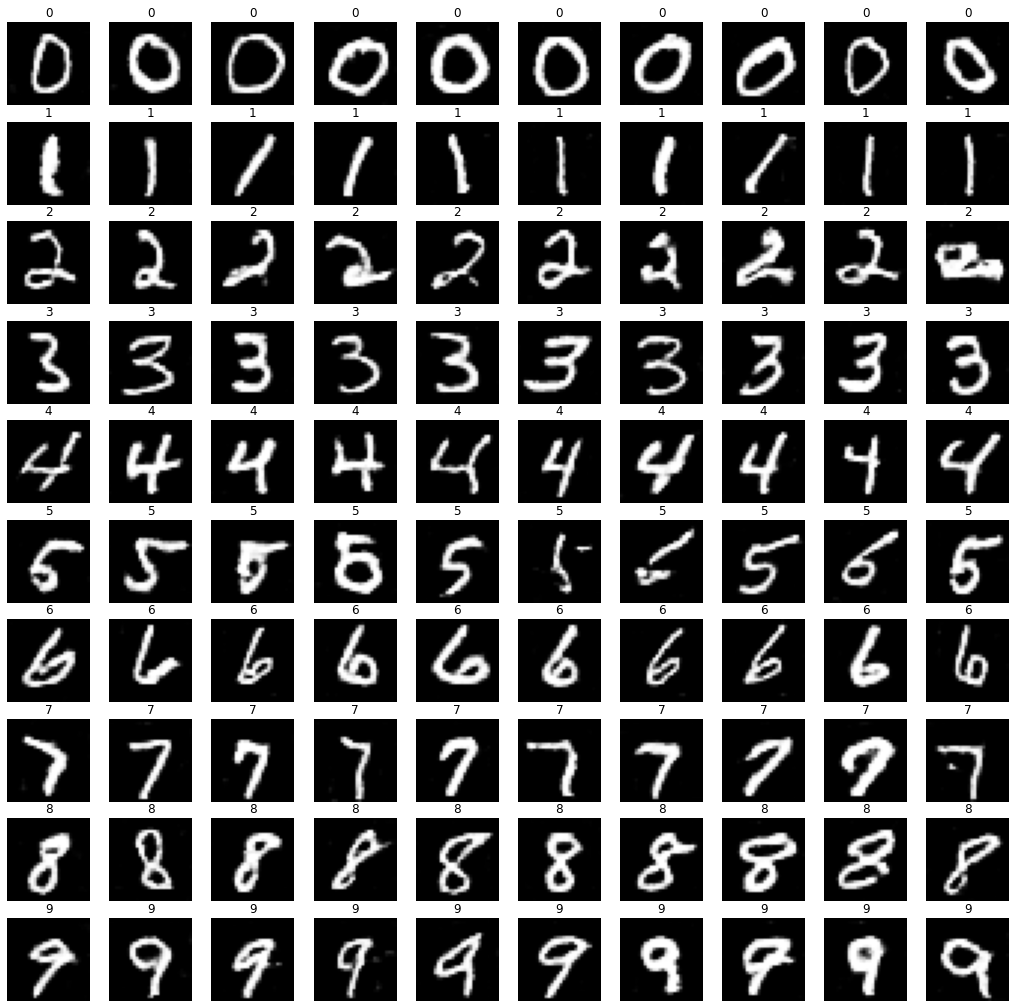

Epoch 15/20:
469/469 [==============================] - 17s 35ms/step
Epoch 16/20:
469/469 [==============================] - 17s 35ms/step


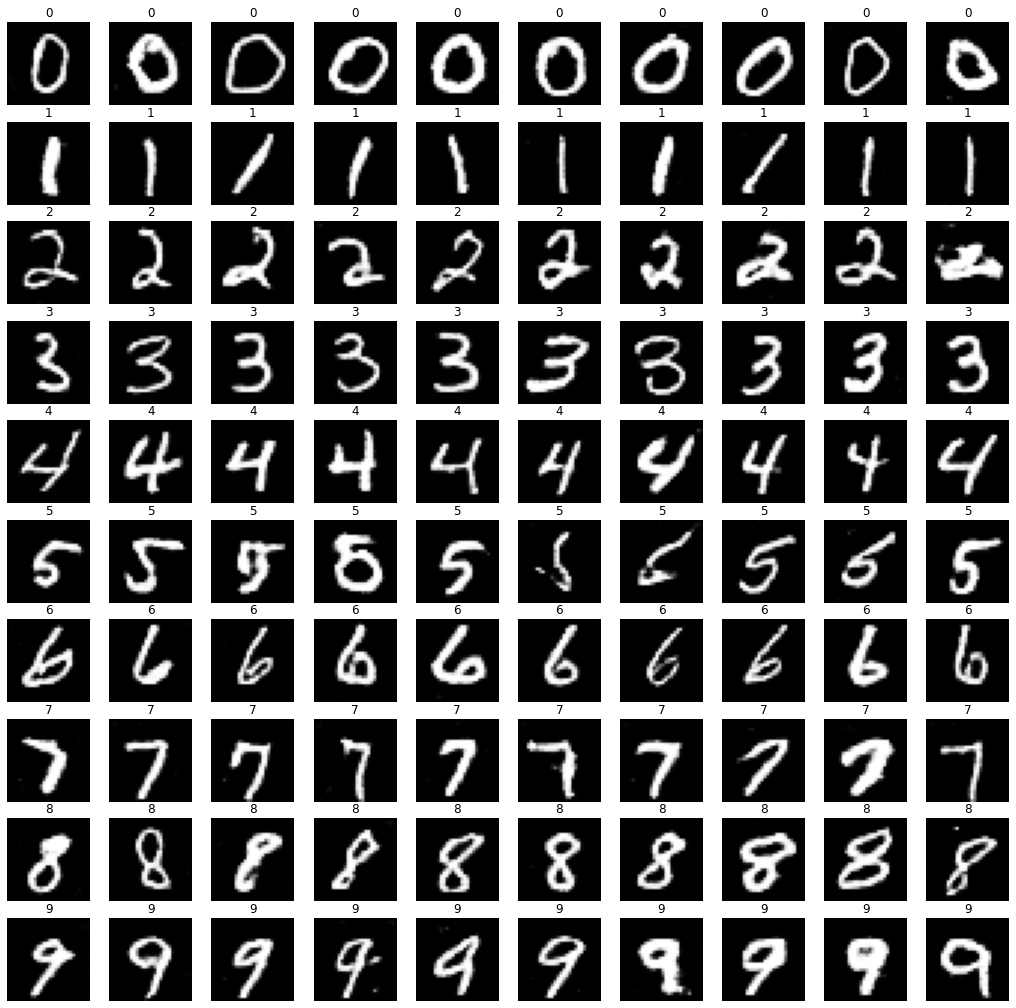

Epoch 17/20:
469/469 [==============================] - 17s 35ms/step
Epoch 18/20:
469/469 [==============================] - 17s 35ms/step


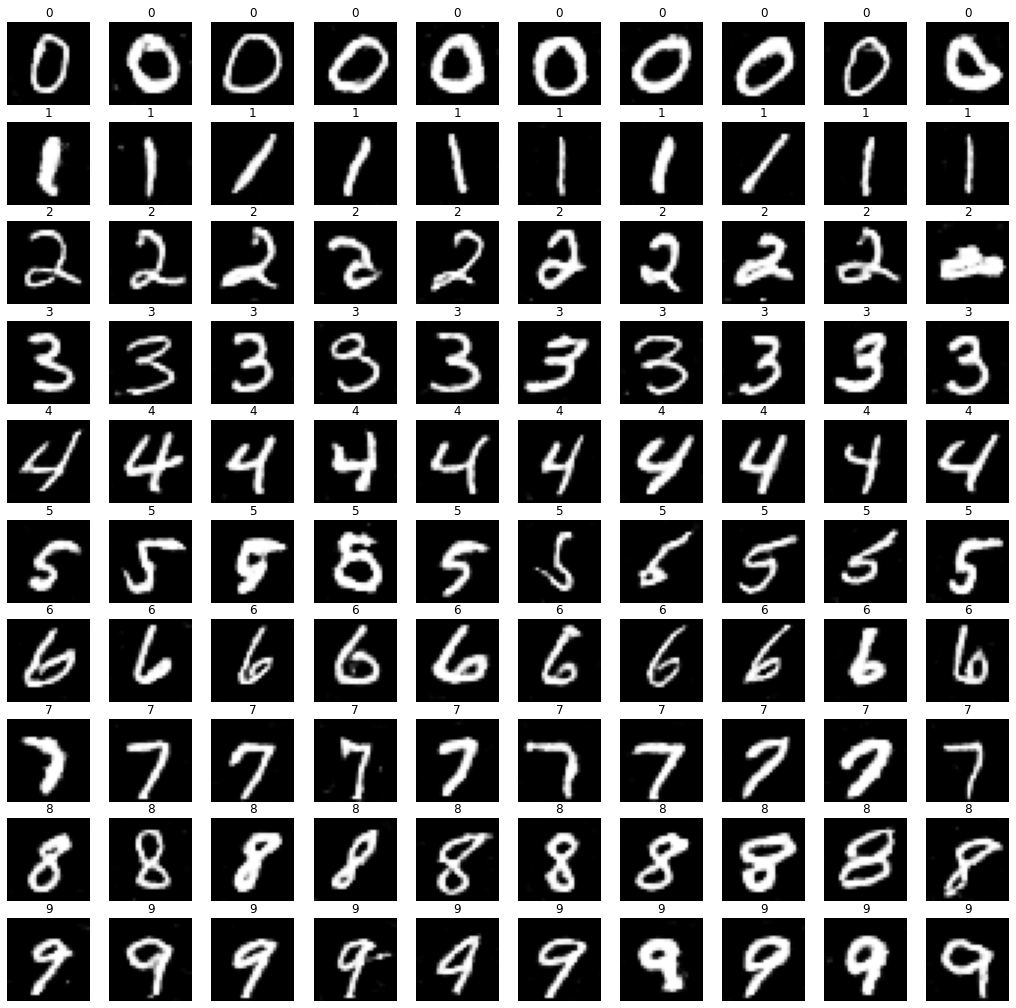

Epoch 19/20:
469/469 [==============================] - 17s 35ms/step
Epoch 20/20:
469/469 [==============================] - 17s 35ms/step


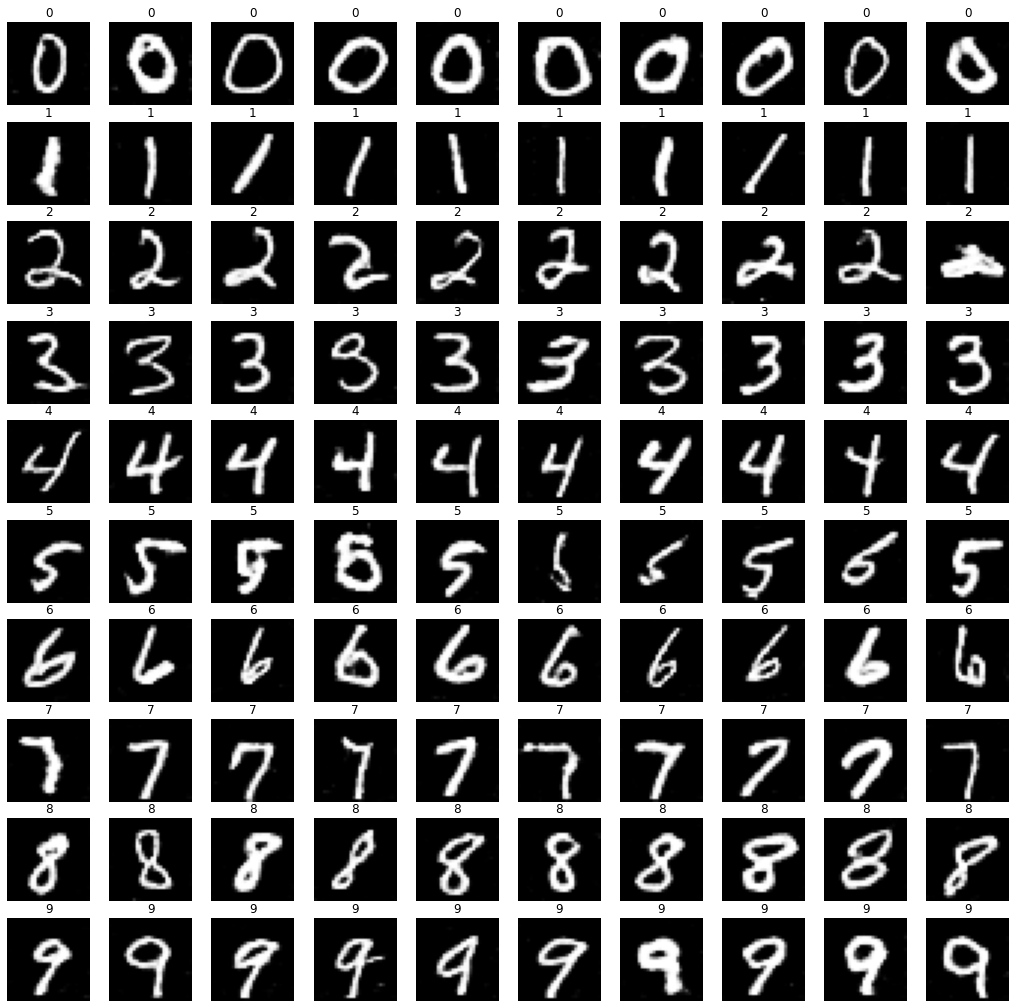

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128
EPOCHS = 20

(ds_train, ds_test), ds_info = tfds.load('mnist', 
                                split=['train', 'test'],
                                as_supervised=True, 
                                with_info=True,
                                shuffle_files=True,
                                )

def normalize(img, label):
    lbl = tf.one_hot(label, WIDTH)
    lbl = tf.reshape(lbl, [1, WIDTH, 1])
    nrm = (tf.cast(img, tf.float32) - 127.5) / 127.5
    return tf.concat([nrm, lbl], axis=0)

ds_unsup = ds_train.map(normalize,  num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_unsup = ds_unsup.cache()
ds_unsup = ds_unsup.shuffle(BUFFER_SIZE)
ds_unsup = ds_unsup.batch(BATCH_SIZE)
ds_unsup = ds_unsup.prefetch(tf.data.experimental.AUTOTUNE)

train(ds_unsup, EPOCHS, ds_info)

## Nearest neighbours Classifier 
We fit a KNN classifier on top of conditionally generated samples and evaluate it's score against real data

In [8]:
def gendata(samples_per_class, batch_size):
  print("Generating data")
  BATCHES = int(samples_per_class/batch_size*CLASSES)
  noises = tf.random.shuffle(noises_per_class(samples_per_class))
  batches = tf.split(noises, BATCHES)
  data = np.empty([0, WIDTH*WIDTH])
  labels = np.array([])
  progbar = tf.keras.utils.Progbar(len(batches))
  for xs in batches:
    ys = tf.math.argmax(tf.slice(xs, [0, NOISE_DIM], [xs.shape[0], CLASSES]), axis=1)
    zs = tf.reshape(G(xs, training=False), [xs.shape[0], -1])
    data = np.concatenate((data, zs), axis=0)
    labels = np.append(labels, ys)
    progbar.add(1)
  return (data, labels)

(kn_train_data, kn_train_labels) = gendata(5000, 1000)
knc = KNeighborsClassifier(5, n_jobs=-1)

print("Building knn")
knc.fit(kn_train_data, kn_train_labels)

print("Evaluating")
(kn_val_data, kn_val_labels) = gendata(100, 1000)
print("Generated data accuracy:")
print(knc.score(kn_val_data, kn_val_labels))

print("Real data accuracy:")
print("Preparing data...")
xs = np.array(list(tfds.as_numpy(ds_test.map(lambda x, _: (tf.cast(tf.reshape(x, [-1]), tf.float32) - 127.5) / 127.5).cache())))
ys = np.array(list(tfds.as_numpy(ds_test.map(lambda _, l: l).cache())))
print("Evaluating")
print(knc.score(xs, ys))

Generating data
50/50 [==============================] - 8s 143ms/step
Building knn
Evaluating
Generating data
1/1 [==============================] - 0s 67ms/step
Generated data accuracy:
0.974
Real data accuracy:
Preparing data...
Evaluating
0.953


## Credits
Some parts of the code are highly inspired by the following sources:
- GAN: https://arxiv.org/abs/1406.2661
- DCGAN: https://arxiv.org/abs/1511.06434 
- Google ML: https://developers.google.com/machine-learning/gan/
- Pytorch: https://pytorch.org/
- TensorFlow: https://www.tensorflow.org/